In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms

Loading MNIST Data

In [83]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Adding noise to MNIST Data

In [84]:
def add_noise(image, mean, std_dev):
    noise = np.random.normal(mean, std_dev, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)  
    return noisy_image

mean_noise = 0
std_dev_noise = 97

mnist_train_data = mnist_train.data.numpy()
mnist_test_data = mnist_test.data.numpy()

noisy_mnist_train_data = add_noise(mnist_train_data, mean_noise, std_dev_noise)  # Clip after adding noise
noisy_mnist_test_data = add_noise(mnist_test_data, mean_noise, std_dev_noise)  # Clip after adding noise

noisy_mnist_train_data = noisy_mnist_train_data / 255.0
noisy_mnist_test_data = noisy_mnist_test_data / 255.0
mnist_train_data = mnist_train_data / 255.0
mnist_test_data = mnist_test_data / 255.0

noisy_mnist_train_data = torch.tensor(noisy_mnist_train_data, dtype=torch.float32)
noisy_mnist_test_data = torch.tensor(noisy_mnist_test_data, dtype=torch.float32)
mnist_train_data = torch.tensor(mnist_train_data, dtype=torch.float32)
mnist_test_data = torch.tensor(mnist_test_data, dtype=torch.float32)

noisy_mnist_train_dataset = torch.utils.data.TensorDataset(noisy_mnist_train_data, mnist_train_data)
noisy_mnist_test_dataset = torch.utils.data.TensorDataset(noisy_mnist_test_data, mnist_test_data)

batch_size = 128
noisy_mnist_train_loader = torch.utils.data.DataLoader(noisy_mnist_train_dataset, batch_size=batch_size, shuffle=True)
noisy_mnist_test_loader = torch.utils.data.DataLoader(noisy_mnist_test_dataset, batch_size=batch_size, shuffle=True)

Visualize the noisy images

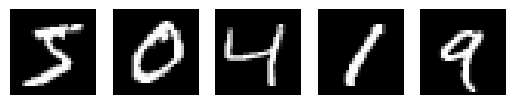

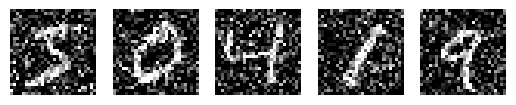

In [109]:
# Original MNIST Data
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(mnist_train_data[i], cmap='gray')
    ax[i].axis('off')
plt.show()

# Noisy MNIST Data
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(noisy_mnist_train_dataset[i][0], cmap='gray')
    ax[i].axis('off')
plt.show()

AutoEncoder Class

In [87]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

Train function

In [93]:
def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    loss_list = []

    for epoch in range(epochs):
        train_loss = 0.0

        for data, labels in train_loader:
            data = data.view(-1, 28 * 28)
            optimizer.zero_grad()
            outputs = model(data)

            labels = labels.view(-1, 28 * 28)
            loss = criterion(outputs, labels)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        print('Epoch: {} Loss: {:.6f}'.format(epoch + 1, train_loss / len(train_loader)))
        loss_list.append(train_loss / len(train_loader))

    return loss_list

Training the model

In [111]:
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 20

loss = train(model, noisy_mnist_train_loader, optimizer, criterion, epochs)

Epoch: 1 Loss: 0.058239
Epoch: 2 Loss: 0.031189
Epoch: 3 Loss: 0.024910
Epoch: 4 Loss: 0.021681
Epoch: 5 Loss: 0.019755
Epoch: 6 Loss: 0.018470
Epoch: 7 Loss: 0.017499
Epoch: 8 Loss: 0.016707
Epoch: 9 Loss: 0.016113
Epoch: 10 Loss: 0.015688
Epoch: 11 Loss: 0.015345
Epoch: 12 Loss: 0.015003
Epoch: 13 Loss: 0.014709
Epoch: 14 Loss: 0.014417
Epoch: 15 Loss: 0.014133
Epoch: 16 Loss: 0.013910
Epoch: 17 Loss: 0.013659
Epoch: 18 Loss: 0.013471
Epoch: 19 Loss: 0.013309
Epoch: 20 Loss: 0.013140


### 2.1

MSE-Plot

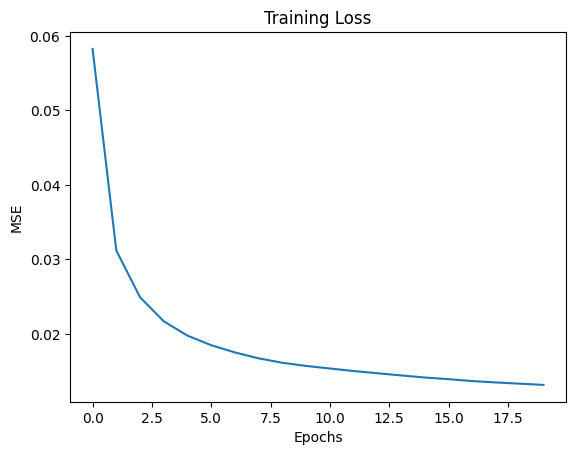

In [112]:
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training Loss')
plt.show()

Test function

In [113]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, 28 * 28)
            outputs = model(data)
            labels = labels.view(-1, 28 * 28)
            test_loss += criterion(outputs, labels).item()

    print('Test Loss: {:.6f}'.format(test_loss / len(test_loader)))

Testing the model

In [114]:
test(model, noisy_mnist_test_loader, criterion)

Test Loss: 0.012998


Visualize the reconstructed images

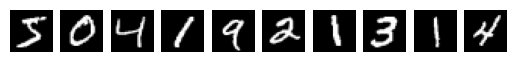

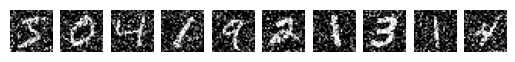

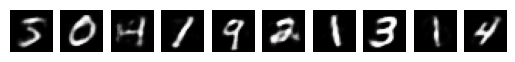

In [110]:
# Original MNIST Data
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(mnist_train_data[i], cmap='gray')
    ax[i].axis('off')

# Noisy MNIST Data
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(noisy_mnist_train_dataset[i][0], cmap='gray')
    ax[i].axis('off')

# Reconstructed MNIST Data
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(model(noisy_mnist_train_dataset[i][0].view(-1, 28 * 28)).detach().numpy().reshape(28, 28), cmap='gray')
    ax[i].axis('off')